# Mc Nemar's test

https://machinelearningmastery.com/mcnemars-test-for-machine-learning/

In [1]:
import os 

RootFolder = "/home/lieberze/DP/Thesis/"
Baseline = os.path.abspath(os.path.join(RootFolder, "04_baseline"))
Adapter = os.path.abspath(os.path.join(RootFolder, "06_adapter"))

XGB_Baseline_binary = os.path.abspath(os.path.join(Baseline, "Models_and_Results/BLBPE/XGBClassifier/pred_labels2x2.pk"))
XGB_Baseline_multilabel = os.path.abspath(os.path.join(Baseline, "Models_and_Results/BLBPE/XGBClassifier/pred_labels3x3.pk"))

Adapter_binary = os.path.abspath(os.path.join(Adapter, "2x2_CV/pred_labels_fold_9_2x2.pk"))
Adapter_multilabel = os.path.abspath(os.path.join(Adapter, "3x3_CV/pred_labels_fold_9_3x3.pk"))

# kdyby nahodou:
DataFolder = os.path.abspath(os.path.join(Baseline, "data"))
TestFolder = os.path.abspath(os.path.join(DataFolder, "test"))
TestFile_Multilabel = os.path.abspath(os.path.join(TestFolder, "Test_holdout_100k.txt"))
TestFile_Binary = os.path.abspath(os.path.join(TestFolder, "2x2_test_100k.txt"))

In [2]:
import pickle
import numpy as np
import pandas as pd

In [3]:
def LoadFile(Name):
    with open(Name, 'rb') as f:
        data = pickle.load(f) 
    return data

### Binary classification

Load the predictions

In [4]:
baseline_2x2 = list(LoadFile(XGB_Baseline_binary))
adapter_2x2 = [x["label"] for x in LoadFile(Adapter_binary)]
true_labels_2x2 = []
with open(TestFile_Binary, "r") as f:
    for i in f:
        true_labels_2x2.append(i.split()[0])
subs = {
        "exon": "exon", 
        "intron": "other",
        "intergenic": "other"
            }
true_labels_2x2 = [subs.get(item) for item in true_labels_2x2]
len(baseline_2x2), len(adapter_2x2), len(true_labels_2x2)

(200000, 200000, 200000)

In [5]:
baseline_2x2[:5], adapter_2x2[:5], true_labels_2x2[:5]

(['exon', 'exon', 'exon', 'other', 'other'],
 ['other', 'other', 'other', 'other', 'exon'],
 ['other', 'exon', 'exon', 'other', 'exon'])

Create a contingency table from the predictions

In [6]:
df = pd.DataFrame({"baseline":baseline_2x2, "adapter": adapter_2x2, "true_labels":true_labels_2x2})
df["hit baseline"] = np.where(df["baseline"] == df["true_labels"], True, False)
df["hit adapter"] = np.where(df["adapter"] == df["true_labels"], True, False)
df.head()

,baseline,adapter,true_labels,hit baseline,hit adapter
0,exon,other,other,False,True
1,exon,other,exon,True,False
2,exon,other,exon,True,False
3,other,other,other,True,True
4,other,exon,exon,False,True


In [7]:
# contingency_table_2x2 = df[["hit baseline", "hit adapter"]]
# contingency_table_2x2.head()

hit_both = int(sum(np.where((df["hit adapter"] == True) & (df["hit baseline"] == True), True, False)))
hit_adapter_only = int(sum(np.where((df["hit adapter"] == True) & (df["hit baseline"] == False), True, False)))
hit_baseline_only = int(sum(np.where((df["hit adapter"] == False) & (df["hit baseline"] == True), True, False)))
hit_none = int(sum(np.where((df["hit adapter"] == False) & (df["hit baseline"] == False), True, False)))

table = [[hit_both, hit_adapter_only], [hit_baseline_only, hit_none]]
sum_numbers = sum([sum(i) for i in table])
print(table, "sum:", sum_numbers)

[[113527, 43509], [21873, 21091]] sum: 200000


In [8]:
# the important ones for the test
hit_adapter_only, hit_baseline_only

(43509, 21873)

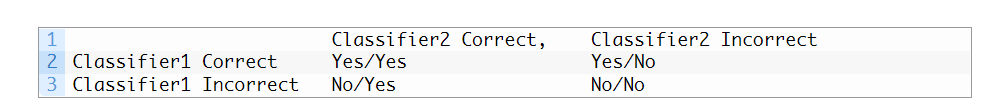

Test

In [9]:
statistic = (np.abs(hit_adapter_only - hit_baseline_only)-1)**2 / (hit_adapter_only + hit_baseline_only)
statistic

7159.053332721544

In [10]:
# Example of calculating the mcnemar test
from statsmodels.stats.contingency_tables import mcnemar
# define contingency table
table = table
# calculate mcnemar test
result = mcnemar(table, exact=False,  correction=True)# summarize the finding
print('statistic=%.3f, p-value=%.3f' % (result.statistic, result.pvalue))
# interpret the p-value
alpha = 0.05
if result.pvalue > alpha:
	print('Same proportions of errors (fail to reject H0)')
else:
	print('Different proportions of errors (reject H0)')

statistic=7159.053, p-value=0.000
Different proportions of errors (reject H0)


Large values?

In [11]:
# https://stats.stackexchange.com/questions/104264/is-this-normal-to-have-big-value-of-chi-squared

### Multilabel classification 
pravdepodobne not the way to go, maybe https://ncss-wpengine.netdna-ssl.com/wp-content/themes/ncss/pdf/Procedures/PASS/Tests_for_Multiple_Correlated_Proportions-McNemar-Bowker_Test_of_Symmetry.pdf)

Load the predictions

In [12]:
baseline_3x3 = list(LoadFile(XGB_Baseline_multilabel))
adapter_3x3 = [x["label"] for x in LoadFile(Adapter_multilabel)]
true_labels_3x3 = []
with open(TestFile_Multilabel, "r") as f:
    for i in f:
        true_labels_3x3.append(i.split()[0])

len(baseline_3x3), len(adapter_3x3), len(true_labels_3x3)

(100000, 100000, 100000)

In [13]:
baseline_3x3[:5], adapter_3x3[:5], true_labels_3x3[:5]

(['intron', 'exon', 'intron', 'exon', 'exon'],
 ['exon', 'intron', 'intergenic', 'intergenic', 'exon'],
 ['intron', 'intron', 'exon', 'intergenic', 'exon'])

Create a contingency table from the predictions

In [14]:
df = pd.DataFrame({"baseline":baseline_3x3, "adapter": adapter_3x3, "true_labels":true_labels_3x3})
df["hit baseline"] = np.where(df["baseline"] == df["true_labels"], True, False)
df["hit adapter"] = np.where(df["adapter"] == df["true_labels"], True, False)
df.head()

,baseline,adapter,true_labels,hit baseline,hit adapter
0,intron,exon,intron,True,False
1,exon,intron,intron,False,True
2,intron,intergenic,exon,False,False
3,exon,intergenic,intergenic,False,True
4,exon,exon,exon,True,True


In [15]:
hit_both = int(sum(np.where((df["hit adapter"] == True) & (df["hit baseline"] == True), True, False)))
hit_adapter_only = int(sum(np.where((df["hit adapter"] == True) & (df["hit baseline"] == False), True, False)))
hit_baseline_only = int(sum(np.where((df["hit adapter"] == False) & (df["hit baseline"] == True), True, False)))
hit_none = int(sum(np.where((df["hit adapter"] == False) & (df["hit baseline"] == False), True, False)))

table = [[hit_both, hit_adapter_only], [hit_baseline_only, hit_none]]
sum_numbers = sum([sum(i) for i in table])
print(table, "sum:",sum_numbers)

[[30444, 26361], [13631, 29564]] sum: 100000


Test

In [16]:
# the important ones for the test
hit_adapter_only, hit_baseline_only

(26361, 13631)

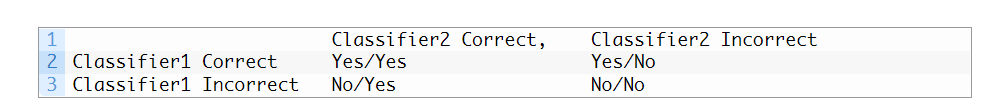

Test

In [17]:
statistic = (np.abs(hit_adapter_only - hit_baseline_only)-1)**2 / (hit_adapter_only + hit_baseline_only)
statistic

4051.496324264853

In [18]:
# Example of calculating the mcnemar test
from statsmodels.stats.contingency_tables import mcnemar
# define contingency table
table = table
# calculate mcnemar test
result = mcnemar(table, exact=False,  correction=True)# summarize the finding
print('statistic=%.3f, p-value=%.3f' % (result.statistic, result.pvalue))
# interpret the p-value
alpha = 0.05
if result.pvalue > alpha:
	print('Same proportions of errors (fail to reject H0)')
else:
	print('Different proportions of errors (reject H0)')

statistic=4051.496, p-value=0.000
Different proportions of errors (reject H0)


In [19]:
myCross = pd.crosstab(df["hit adapter"], df["hit baseline"])
myCross

hit baseline,False,True
hit adapter,,
False,29564,13631
True,26361,30444


In [20]:
# https://www.youtube.com/watch?v=Utj0OPjRE30

In [21]:
from statsmodels.stats.api import SquareTable
print("'df' == degrees of freedom")
print(SquareTable(myCross, shift_zeros=False).symmetry())

'df' == degrees of freedom
df          1.0
pvalue      0.0
statistic   4052.132926585317


In [22]:
# !pip install researchpy
from researchpy import crosstab

In [23]:
# https://colab.research.google.com/drive/1OhZhlALD4QtMkhBtvcPvhLRlSM-ZKtAq#scrollTo=K04wprg7sCpH
def bowkerPHmc(data, field1, field2):
    myDf = data[[field1,field2]]
    
    categories=myDf[field1].unique()
    categories
    

    # the number of categories (should be equal for both variables)
    k = len(categories)
    # the number of tests that will be performed
    K = (k*(k-1))/2
    # an empty dataframe for the results later
    phMcNemar = pd.DataFrame(columns=['category 1', 'category 2', 'chi2 value', 'p-unadj.', 'p-adj.'])

    for i in range(0,k-1):
        for j in range(i+1,k):
            sel1 = categories[i]
            sel2 = categories[j]
            tempDf = myDf[((myDf[field1] == sel1) | (myDf[field1] == sel2)) & ((myDf[field2] == sel1) | (myDf[field2] == sel2))]
            
            # using the chi-square approximation and no continuity correction
            crosstable, res = crosstab(tempDf[field1], tempDf[field2], test= "mcnemar", exact=False, correction=False)

            chiVal = res['results'][0]
            punadj = res['results'][1]

            # adjust using the Bonferroni method:
            padj = punadj * K
            # set to 1 if larger than 1.
            if padj>1:
                padj=1

            # add results to dataframe
            newRow = {'category 1':sel1, 'category 2':sel2, 'chi2 value':chiVal, 'p-unadj.':punadj, 'p-adj.':padj}
            phMcNemar = phMcNemar.append(newRow, ignore_index=True) 

    return phMcNemar    

In [24]:
bowkerPHmc(df, "adapter", "true_labels"), bowkerPHmc(df, "baseline", "true_labels")

(  category 1  category 2  chi2 value  p-unadj.  p-adj.
 0       exon      intron   1272.9358       0.0     0.0
 1       exon  intergenic    124.0308       0.0     0.0
 2     intron  intergenic     36.9689       0.0     0.0,
   category 1  category 2  chi2 value  p-unadj.  p-adj.
 0     intron        exon   5161.1324       0.0     0.0
 1     intron  intergenic    556.0597       0.0     0.0
 2       exon  intergenic   4036.0130       0.0     0.0)

In [25]:
# pro multilabel + tabulka a support
# plus sloupečky cat1, cat2 support
bowkerPHmc(df, "baseline", "adapter")

,category 1,category 2,chi2 value,p-unadj.,p-adj.
0,intron,exon,11045.1254,0.0000,0.0000
1,intron,intergenic,16.2722,0.0001,0.0003
2,exon,intergenic,4220.6830,0.0000,0.0000


## F-test for baseline + adapter and baseline only

The F-Test for Comparing Multiple Classifiers: https://sebastianraschka.com/blog/2018/model-evaluation-selection-part4.html#the-f-test-for-comparing-multiple-classifiers


Code: http://rasbt.github.io/mlxtend/user_guide/evaluate/ftest/

In [79]:
Names = ['RandomForestClassifier',
         'GradientBoostingClassifier',
         'RidgeClassifier',
         'MLPClassifier',
         'LogisticRegression',
         'XGBClassifier',
         'Adapter']

In [88]:
# Binary_values = [{'mean': '0.552', 'std': '0.004'},
#                  {'mean': '0.623', 'std': '0.003'},
#                  {'mean': '0.581', 'std': '0.004'},
#                  {'mean': '0.561', 'std': '0.017'},
#                  {'mean': '0.548', 'std': '0.009'},
#                  {'mean': '0.646', 'std': '0.003'},
#                  {'mean': '0.782', 'std': '0.003'}]
# Multilabel_values = [{'mean': '0.339', 'std': '0.003'},
#                      {'mean': '0.416', 'std': '0.003'},
#                      {'mean': '0.361', 'std': '0.004'},
#                      {'mean': '0.291', 'std': '0.021'},
#                      {'mean': '0.344', 'std': '0.003'},
#                      {'mean': '0.418', 'std': '0.004'},
#                      {'mean': '0.572', 'std': '0.003'}]

### Binary classification

In [28]:
import pickle
import pprint
import numpy as np

pp = pprint.PrettyPrinter(indent=4)

predicted_2x2 = {}


ResultsFolder = "Models_and_Results"
TokenizerAlgorithm = "BLBPE" # else "CharBPE"
suffix="2x2"

#baseline
for baseline in Names[:-1]:
    ModelFolderName = str(baseline).split("(")[0]   
    Path = f"/home/lieberze/DP/Thesis/04_baseline/{ResultsFolder}/{TokenizerAlgorithm}/{ModelFolderName}"
    x = LoadFile(f"{Path}/pred_labels{suffix}.pk")
    print(len(x))
    predicted_2x2[ModelFolderName] = x

#adapter
adapter = "/home/lieberze/DP/Thesis/06_adapter/2x2_CV/pred_labels_fold_9_2x2.pk"
x = LoadFile(adapter)
subs = {
        "exon": "exon", 
        "intron": "other",
        "intergenic": "other"
            }
x = [item["label"] for item in x]
print(len(x))
predicted_2x2["Adapter"] = np.array(x)
pp.pprint(predicted_2x2)

print("True labels:",true_labels_2x2[:10])

200000
200000
200000
200000
200000
200000
200000
{   'Adapter': array(['other', 'other', 'other', ..., 'other', 'exon', 'other'],
      dtype='<U5'),
    'GradientBoostingClassifier': array(['other', 'exon', 'exon', ..., 'exon', 'other', 'other'],
      dtype='<U5'),
    'LogisticRegression': array(['exon', 'exon', 'exon', ..., 'other', 'exon', 'other'], dtype='<U5'),
    'MLPClassifier': array(['exon', 'exon', 'other', ..., 'exon', 'exon', 'other'], dtype='<U5'),
    'RandomForestClassifier': array(['exon', 'exon', 'exon', ..., 'exon', 'exon', 'other'], dtype='<U5'),
    'RidgeClassifier': array(['other', 'exon', 'exon', ..., 'other', 'other', 'other'],
      dtype='<U5'),
    'XGBClassifier': array(['exon', 'exon', 'exon', ..., 'other', 'exon', 'other'], dtype='<U5')}
True labels: ['other', 'exon', 'exon', 'other', 'exon', 'other', 'other', 'other', 'other', 'exon']


F-test for adapter + baseline

In [76]:
import numpy as np
# pip install mlxtend
from mlxtend.evaluate import ftest

# # Unpacking list into four arguments
# fun(*my_list)

f, p_value = ftest(np.array(true_labels_2x2), 
                   *list(predicted_2x2.values())
                  )

print('F: %.3f' % f)
print('p-value: %.3f' % p_value)

F: 10145.686
p-value: 0.000


F-test for baseline only

In [78]:
f, p_value = ftest(np.array(true_labels_2x2), 
                   predicted_2x2["GradientBoostingClassifier"],
                   predicted_2x2["LogisticRegression"],
                   predicted_2x2["MLPClassifier"],
                   predicted_2x2["RandomForestClassifier"],
                   predicted_2x2["RidgeClassifier"],
                   predicted_2x2["XGBClassifier"],
                  )
print('F: %.3f' % f)
print('p-value: %.3f' % p_value)

F: 4157.132
p-value: 0.000


### Multi-label classification

In [74]:
import pickle
import numpy as np
predicted_3x3 = {}

ResultsFolder = "Models_and_Results"
TokenizerAlgorithm = "BLBPE" # else "CharBPE"
suffix="3x3"

#baseline
for baseline in Names[:-1]:
    ModelFolderName = str(baseline).split("(")[0]   
    Path = f"/home/lieberze/DP/Thesis/04_baseline/{ResultsFolder}/{TokenizerAlgorithm}/{ModelFolderName}"
    x = LoadFile(f"{Path}/pred_labels{suffix}.pk")
    print(len(x))
    predicted_3x3[ModelFolderName] = x

#adapter
adapter = "/home/lieberze/DP/Thesis/06_adapter/3x3_CV/pred_labels_fold_9_3x3.pk"
x = LoadFile(adapter)
x = [item["label"] for item in x]
print(len(x))
predicted_3x3["Adapter"] = np.array(x)
pp.pprint(predicted_3x3)

print("True labels:",true_labels_3x3[:10])

100000
100000
100000
100000
100000
100000
100000
{   'Adapter': array(['exon', 'intron', 'intergenic', ..., 'exon', 'exon', 'intergenic'],
      dtype='<U10'),
    'GradientBoostingClassifier': array(['exon', 'exon', 'intron', ..., 'exon', 'intergenic', 'intergenic'],
      dtype='<U10'),
    'LogisticRegression': array(['exon', 'intron', 'exon', ..., 'exon', 'exon', 'intergenic'],
      dtype='<U10'),
    'MLPClassifier': array(['exon', 'intergenic', 'intergenic', ..., 'exon', 'exon', 'exon'],
      dtype='<U10'),
    'RandomForestClassifier': array(['exon', 'exon', 'exon', ..., 'exon', 'exon', 'intergenic'],
      dtype='<U10'),
    'RidgeClassifier': array(['exon', 'exon', 'exon', ..., 'exon', 'exon', 'intergenic'],
      dtype='<U10'),
    'XGBClassifier': array(['intron', 'exon', 'intron', ..., 'intron', 'intron', 'intergenic'],
      dtype='<U10')}
True labels: ['intron', 'intron', 'exon', 'intergenic', 'exon', 'intron', 'intergenic', 'intron', 'intron', 'exon']


F-test for adapter + baseline

In [65]:
import numpy as np
# pip install mlxtend
from mlxtend.evaluate import ftest

# # Unpacking list into four arguments
# fun(*my_list)

f, p_value = ftest(np.array(true_labels_3x3), 
                   *list(predicted_3x3.values())
                  )

print('F: %.3f' % f)
print('p-value: %.3f' % p_value)

F: 3451.300
p-value: 0.000


F-test for baseline only

In [72]:
f, p_value = ftest(np.array(true_labels_3x3), 
                   predicted_3x3["GradientBoostingClassifier"],
                   predicted_3x3["LogisticRegression"],
                   predicted_3x3["MLPClassifier"],
                   predicted_3x3["RandomForestClassifier"],
                   predicted_3x3["RidgeClassifier"],
                   predicted_3x3["XGBClassifier"],
                  )
print('F: %.3f' % f)
print('p-value: %.3f' % p_value)

F: 899.913
p-value: 0.000
